<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Цели-проекта" data-toc-modified-id="Цели-проекта-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Цели проекта</a></span></li><li><span><a href="#Ход-исследования" data-toc-modified-id="Ход-исследования-0.3"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>Ход исследования</a></span></li></ul></li><li><span><a href="#Загрузка-и-предобработка-данных" data-toc-modified-id="Загрузка-и-предобработка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и предобработка данных</a></span></li><li><span><a href="#Исследовательский-и-корреляционный-анализ-данных" data-toc-modified-id="Исследовательский-и-корреляционный-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский и корреляционный анализ данных</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Обучение-и-оценка-моделей" data-toc-modified-id="Обучение-и-оценка-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение и оценка моделей</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

#  Проект по прогнозированию заказов такси

### Описание проекта
**Заказчик:** Компания «Чётенькое такси»

**Описание данных** 

Датасет содержит исторические данные о заказах такси в аэропортах.

### Цели проекта 

Построить модель для прогнозирования количества заказов такси. Это нужно, чтобы правильно определять период пиковой нагрузки и привлекать больше водителей в это время.  Количество заказов — непрерывная количественная величина, соответственно, в ходе проекта будет решена задача регрессии.


Дополнительное условие: значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Ход исследования

- **Загрузка и предобработка данных**: загрузка и изучение общей информации о предоставленном датасете, ресемплирование данных по одному часу. Корректировка типов данных, дубликатов и пропусков.

- **Анализ данных**: создание признаков, описание и визуалиция информации обо всех признаках, устранение аномалий. Корреляционный анализ

- **Подготовка данных**: кодирование и масштабирование признаков перед обучением модели.

- **Обучение и оценка моделей**: обучение моделей для задачи регрессии, подбор гиперпараметров. Оценка качества моделей, выбор лучшей модели  и её проверка на тестовой выборке.

- **Общий вывод** и подведение итогов по проделанным работам, рекомендации заказчику.

In [1]:
!pip install --upgrade scikit-learn -q

In [2]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns
import lightgbm as lgb

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import (
                                    RandomizedSearchCV,
                                    train_test_split,
                                    TimeSeriesSplit
                                )
from sklearn.preprocessing import (
                                    StandardScaler,
                                    OneHotEncoder
                                )
from sklearn.metrics import (
                             mean_squared_error,
                             make_scorer
)


RANDOM_STATE = 42

## Загрузка и предобработка данных

<a href="#Содержание">Назад к содержанию</a>

Для начала загрузим данные. Применим библиотеку os, чтобы убедиться в корректности пути, по которому находится датасет.

In [3]:
pth = 'taxi_time_series.csv'
if os.path.exists(pth):
    taxi = pd.read_csv(pth)
    display(taxi.sample(5), taxi.shape)
else:
    print('Something is wrong')

,datetime,num_orders
23637,2018-08-12 03:30:00,14
3464,2018-03-25 01:20:00,22
17796,2018-07-02 14:00:00,4
23505,2018-08-11 05:30:00,11
23220,2018-08-09 06:00:00,10


(26496, 2)

Всего в датасете 2 признака и 26496 наблюдений. Далее проведём предобработку данных, а после её завершения — ресэмплирование по одному часу. Выведем общую информацию о данных на экран:

In [4]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Количество ненулевых значений по каждому признаку совпадает с количеством строк — значит, пропусков в данных нет. С названиями признаков также всё в порядке, они написаны в стиле snake_case. Однако в столбце datetime тип данных стоит поменять на соответствующий (datetime), а не object.

In [5]:
taxi['datetime'] = pd.to_datetime(taxi['datetime'])
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Типы данных теперь проставлены корректно. Проверим датасет на наличие полных дубликатов.

In [6]:
taxi.duplicated().sum()

0

Полных дубликатов нет, проверим на наличие неполных по столбцу datetime

In [7]:
taxi['datetime'].value_counts()

2018-03-09 22:10:00    1
2018-07-20 13:00:00    1
2018-04-07 16:50:00    1
2018-05-13 22:40:00    1
2018-03-06 22:30:00    1
                      ..
2018-06-22 17:10:00    1
2018-06-06 20:00:00    1
2018-04-20 04:30:00    1
2018-04-04 07:20:00    1
2018-06-26 15:40:00    1
Name: datetime, Length: 26496, dtype: int64

С помощью value_counts мы выяснили, что для каждого уникального значения datetime есть только одна строка в датафрейме. Далее перенёсем в индекс датасета столбец datetime и убедимся, что он является монотонным. Если это так — проведём ресэплирование по часу.

In [8]:
taxi.set_index('datetime', inplace=True)
taxi.index.is_monotonic

True

In [9]:
taxi = taxi.resample('1H').sum()
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Длина датасета стало ровно в 6 раз меньше: всё логично, так как ранее количество заказов было прописано за каждые 10 минут.

**Вывод по загрузке и предобработке данных**

- Изначальный размер датасета — 2 признака и 26496 наблюдений;
- Названия признаков написаны в корректном змеином регистре;
- Изначально датасет состоит из двух типов данных — object (столбец datetime) и int (столбец num_orders);
- Пропусков в данных не обнаружено;
- Дубликатов в данных не обнаружено;
- По столбцу datetime тип данных заменён на datetime;
- Столбец datetime перемещён в индекс датасета, также произведено ресэмплирование данных по одному часу. В результате его длина сократилась в 6 раз (4416 строк)

## Исследовательский и корреляционный анализ данных

<a href="#Содержание">Назад к содержанию</a>

Сейчас в нашем датасете по сути находится только целевой признак — num_orders. Перед тем, как приступать к анализу, создадим несколько входных признаков на основе даты и времени. Это нужно, чтобы в дальнейшем нашим моделям было на чём обучаться. После создания признаков проанализируем их вместе с целевым.

Для начала проверим, за какие годы датасет содержит информацию и есть ли смысл делать для года отдельный признак.

In [10]:
taxi.index.year.unique()

Int64Index([2018], dtype='int64', name='datetime')

У года только одно уникальное значение — 2018, соответственно, нет смысла делать признак year. Он не будет нести в себе полезной информации для обучения моделей.

In [11]:
taxi.index.month.unique()

Int64Index([3, 4, 5, 6, 7, 8], dtype='int64', name='datetime')

Месяцев в данных 6: с марта по август. Создавать на их основе отдельный признак не будем — более информативными для исследования будут признаки hour и day_of_week. (ведь в разное время дня и разные дни недели нагрузка на службы такси меняется. Модели должны это учитывать)

In [12]:
taxi['hour'] =  taxi.index.hour
taxi['day_of_week'] = taxi.index.dayofweek
taxi.sample(5)

,num_orders,hour,day_of_week
datetime,,,
2018-04-11 08:00:00,60,8,2
2018-07-09 20:00:00,59,20,0
2018-07-29 09:00:00,98,9,6
2018-05-05 22:00:00,75,22,5
2018-04-21 01:00:00,119,1,5


Теперь проанализируем каждый из признаков.

'Описание признака: num_orders'

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

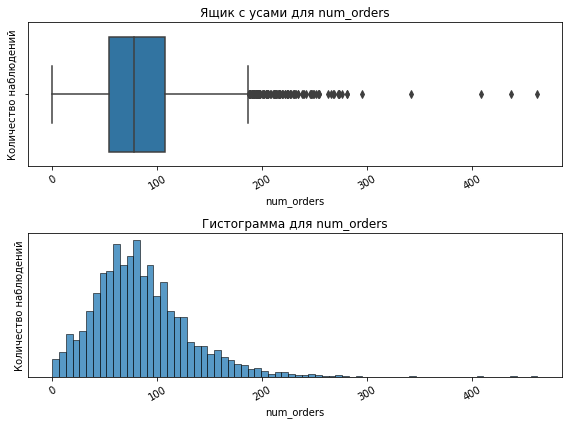

In [13]:
plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 1)
sns.boxplot(data=taxi, x='num_orders')
plt.title('Ящик с усами для num_orders')
plt.ylabel('Количество наблюдений')
plt.xlabel('num_orders')
plt.xticks(rotation=30)

plt.subplot(2, 1, 2)
sns.histplot(data=taxi, x='num_orders')
plt.title('Гистограмма для num_orders')
plt.gca().set_yticks([])
plt.ylabel('Количество наблюдений')
plt.xlabel('num_orders')
plt.xticks(rotation=30)

display(f'Описание признака: num_orders',
        taxi['num_orders'].describe()
       )

plt.tight_layout()   
plt.show()    

Признак num_orders (в отрыве от его динамики во времени) распределён нормально со средним в 84.4 заказов в час. Минимальное значение 0 вполне реалистично — в тот или иной час действительно может вообще не быть заказов. Но максимальное число 462 заказов/час уже вызывает вопросы.

У нас нет информации о том, в какие аэропорты были эти заказы. По названию компании  «Чётенькое такси» можно предположить, что она работает в России. 

В таком случае, сделаем следующее допущение. В наш датасет входят данные о самых крупных аэропортах нашей страны (Шереметьево, Домодедово и Внуково). По информации chat gpt, 

*«В часы пик (утро и вечер):
В крупных аэропортах, таких как Шереметьево и Домодедово, количество заказов такси в час может достигать от 300 до 800+ заказов.*

*Средние показатели: Обычно в не пиковое время это число снижается до 100–300 заказов в час.*

Делаем вывод, что 462 заказа в час пик — это вариант нормы, удалять или изменять такие значения не нужно.

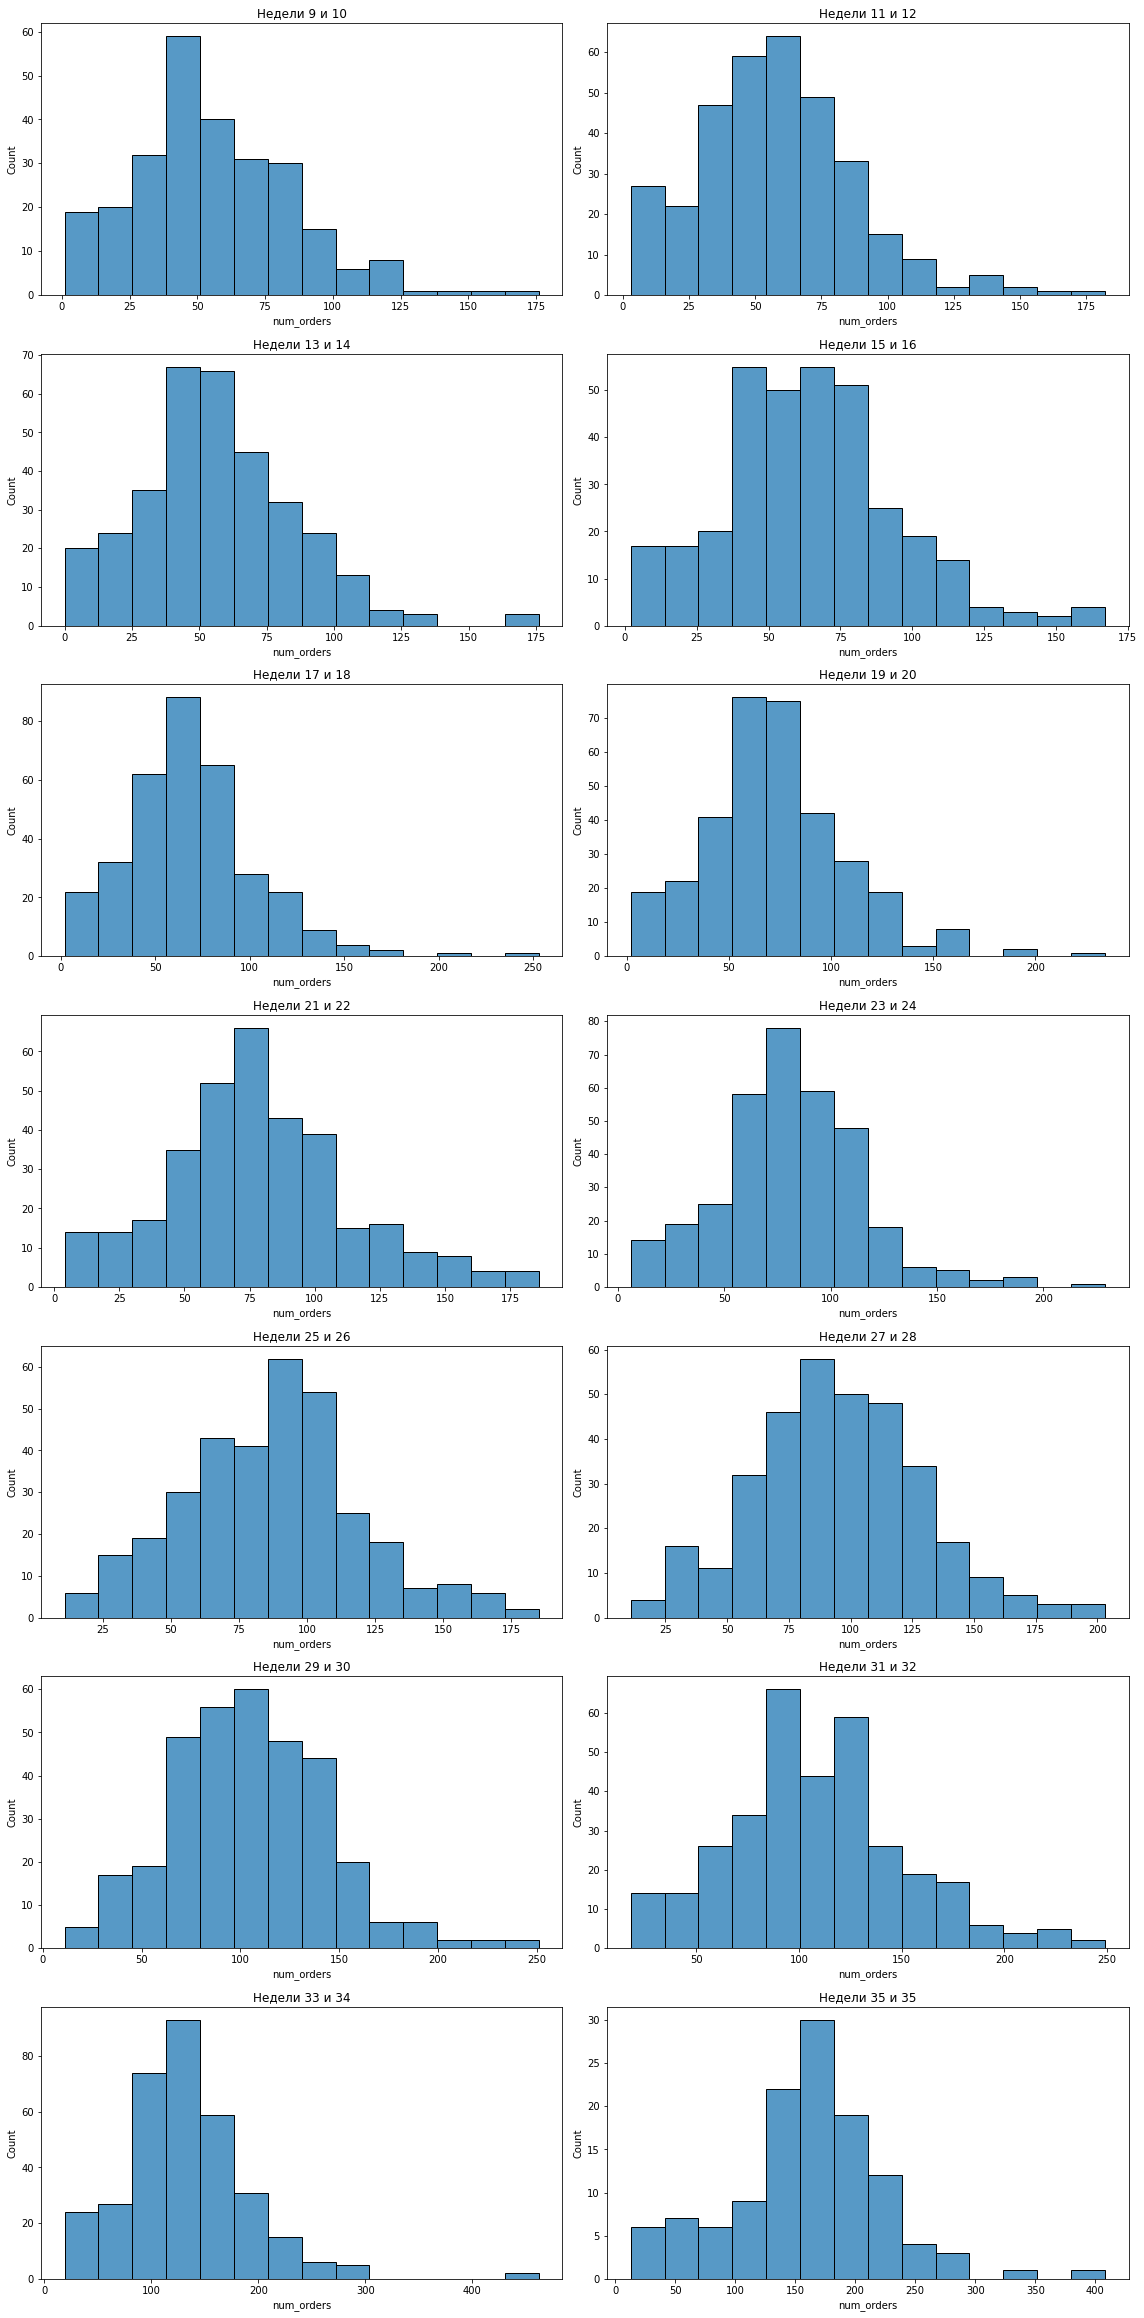

In [14]:
weeks = sorted(taxi.index.isocalendar().week.unique())

plt.figure(figsize=(16, 64))

for i in range(0, len(weeks), 2):
    week_pair = weeks[i:i+2]
    plt.subplot((len(weeks) + 1) // 2, 2, i//2 + 1)
    data_pair = taxi[taxi.index.isocalendar().week.isin(week_pair)]
    sns.histplot(data=data_pair, x='num_orders', bins=14)
    plt.title(f'Недели {week_pair[0]} и {week_pair[-1]}')

plt.tight_layout()
plt.show()

Выше была произведена визуализация целевого признака по временным промежуткам в 2 недели. Тип распределения сохраняется такой же, как и у совокупности в целом — нормальный.

Далее построим столбчатые диаграммы по каждому из дискретных признаков.

'Частота значений для признака: hour'

0     184
1     184
2     184
3     184
4     184
5     184
6     184
7     184
8     184
9     184
10    184
11    184
12    184
13    184
14    184
15    184
16    184
17    184
18    184
19    184
20    184
21    184
22    184
23    184
Name: hour, dtype: int64

'Частота значений для признака: day_of_week'

0    624
1    624
2    624
3    648
4    648
5    624
6    624
Name: day_of_week, dtype: int64

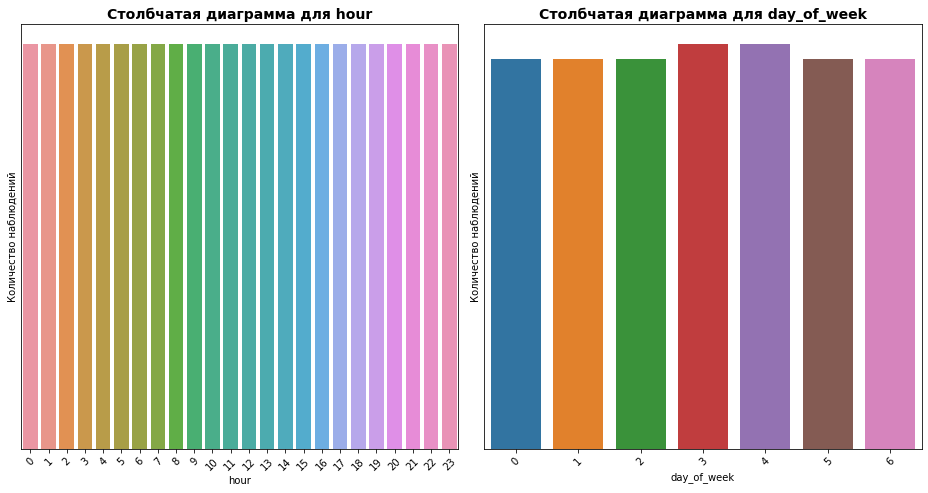

In [15]:
discrete_features = [
                    'hour',
                    'day_of_week'
                    ]

plt.figure(figsize=(13, 13))
for i, feature in enumerate(discrete_features, start=1):
    
    plt.subplot(2, 2, i)
    sns.countplot(data=taxi, x=feature)
    plt.title(f'Столбчатая диаграмма для {feature}', fontweight='bold', fontsize=14)
    plt.gca().set_yticks([])
    plt.ylabel('Количество наблюдений')
    plt.xlabel(feature)
    plt.xticks(rotation=45)
    
    display(f'Частота значений для признака: {feature}',
            taxi[feature].value_counts().sort_index()
           )  
plt.tight_layout()   
plt.show()

Эти диаграммы несут довольно мало информации для анализа, значения распределены практически поровну. Актуально для обоих признаков. 

- Признак hour. Для всех часов количество наблюдений — 184, они распределены поровну.


- Признак day_of_week. Наибольшее число наблюдений было для четверга и пятницы (648), наименьшее (624) - для понедельника, вторника, среды, субботы и воскресенья.

Далее построим более информативный график с помощью тепловой карты. Он позволит нам понять, в какие часы каких дней недели было больше всего заказов, в среднем.

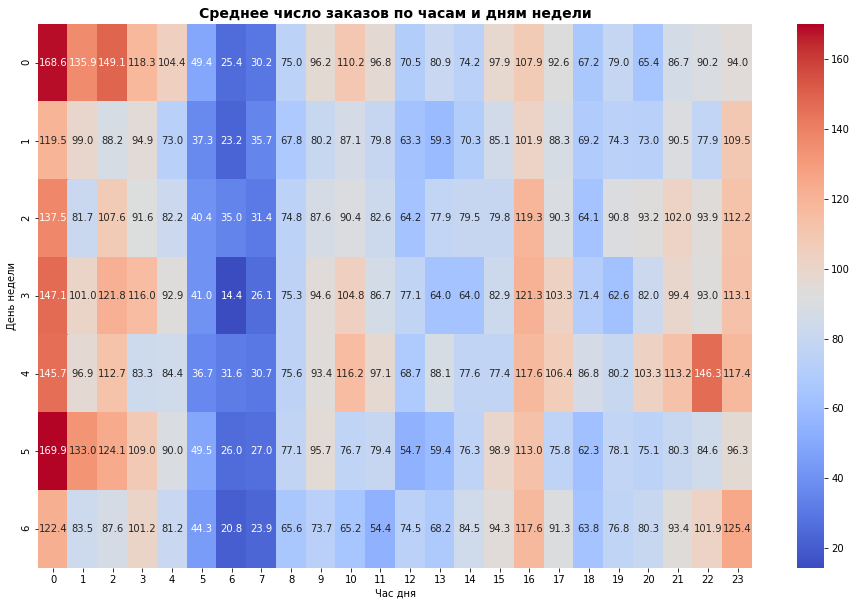

In [16]:
pivot_table = taxi.pivot_table(values='num_orders', index='day_of_week', columns='hour', aggfunc='mean')

plt.figure(figsize=(16,10))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap='coolwarm')
plt.title('Среднее число заказов по часам и дням недели', fontsize=14, fontweight='bold')
plt.xlabel('Час дня')
plt.ylabel('День недели')
plt.show()

- Самое высокое среднее число заказов было в понедельник в 0:00 (168.6), а также в субботу в 0:00 (169.9)
- Также высокие значения характерны для среды в 0:00 (137.5),четверга в 0:00 (147.1), пятницы в 0:00 (145.7) и в 22:00 (146.3), субботы в 1:00 (133)
- Самое низкое среднее число заказов — вторник в 6:00 (23.2), четверг в 6:00 (14.4), воскресенье в 6:00 (20.8).

Далее на основании скользящего среднего визуализируем тренд, сезонность и остатки целевого признака.

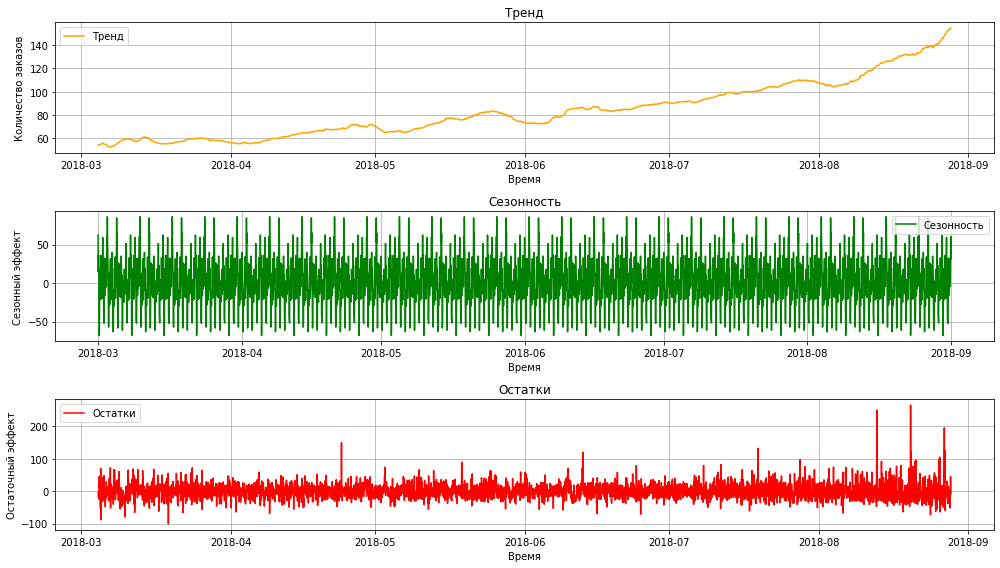

In [17]:
decomposition = seasonal_decompose(taxi['num_orders'], model='additive', period=168)

plt.figure(figsize=(14, 8))

plt.subplot(3, 1, 1)
plt.plot(decomposition.trend, label='Тренд', color='orange')
plt.title('Тренд')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.legend()
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(decomposition.seasonal, label='Сезонность', color='green')
plt.title('Сезонность')
plt.xlabel('Время')
plt.ylabel('Сезонный эффект')
plt.legend()
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(decomposition.resid, label='Остатки', color='red')
plt.title('Остатки')
plt.xlabel('Время')
plt.ylabel('Остаточный эффект')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

- график тренда показывает устойчивое увеличение скользящего среднего числа заказов с течением времени. То есть, в августе в среднем заказов было больше, чем в марте;

- график сезонности показывает, что у целевого признака есть регулярные колебания. То есть, в поведении заказов действительно есть устойчивые паттерны. В определенную часть недели их среднее число увеличивается, а затем уменьшается;

- явных паттернов или трендов на графике остатков нет — они хаотичны.

Также добавим в датасет 2 новых признака на основе нашего таргета — лаговые значения и скользящее среднее. И тот, и другой признак будут основываться в данных за неделю (168 часов).

In [18]:
taxi['lag_values'] = taxi['num_orders'].shift(168)
taxi['rolling_mean'] = taxi['num_orders'].shift().rolling(168).mean()
display(taxi.head(), taxi.isna().sum())

,num_orders,hour,day_of_week,lag_values,rolling_mean
datetime,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN
2018-03-01 01:00:00,85,1,3,NaN,NaN
2018-03-01 02:00:00,71,2,3,NaN,NaN
2018-03-01 03:00:00,66,3,3,NaN,NaN
2018-03-01 04:00:00,43,4,3,NaN,NaN


num_orders        0
hour              0
day_of_week       0
lag_values      168
rolling_mean    168
dtype: int64

Теперь нужно удалить первые 168 строк датасета — линейная регрессия не сможет обработать пропуски.

In [19]:
taxi = taxi.dropna(subset=['lag_values', 'rolling_mean'])
taxi.isna().sum()

num_orders      0
hour            0
day_of_week     0
lag_values      0
rolling_mean    0
dtype: int64

**Вывод по исследовательскому анализу данных**

- В данные добавлено 4 новых признака — час, день недели, лаговые значения за неделю и скользяшее среднее с окном в неделю.


Визуализация и анализ признаков


- Признак num_orders распределён нормально со средним в 84.4 заказов в час. Минимальное значение 0, максимальное — 462. Также  проведена его визуализация по временным промежуткам в 2 недели. Распределение получилось такое же, как и у совокупности в целом — нормальное.

- Признак hour. Для всех часов количество наблюдений — 184, они распределены поровну.


- Признак day_of_week. Наибольшее число наблюдений было для четверга и пятницы (648), наименьшее (624) - для понедельника, вторника, среды, субботы и воскресенья.


Анализ тепловой карты


- Самое высокое среднее число заказов было в понедельник в 0:00 (168.6), а также в субботу в 0:00 (169.9)


- Также высокие значения характерны для среды в 0:00 (137.5),четверга в 0:00 (147.1), пятницы в 0:00 (145.7) и в 22:00 (146.3), субботы в 1:00 (133)


- Самое низкое среднее число заказов — вторник в 6:00 (23.2), четверг в 6:00 (14.4), воскресенье в 6:00 (20.8).


Анализ трендов, сезонности и остатков

- график тренда показывает устойчивое увеличение скользящего среднего числа заказов с течением времени. То есть, в августе в среднем заказов было больше, чем в марте;

- график сезонности показывает, что у целевого признака есть регулярные колебания. То есть, в поведении заказов действительно есть устойчивые паттерны. В определенную часть недели их среднее число увеличивается, а затем уменьшается;

- явных паттернов или трендов на графике остатков нет — они хаотичны.



Также были удалены первые 168 строк датасета: в них значения признаков 'lag_values' и 'rolling_mean' пропущены. Модель линейной регрессии не сможет обучаться на пропусках.

Далее проведём корреляционный анализ наших признаков. 

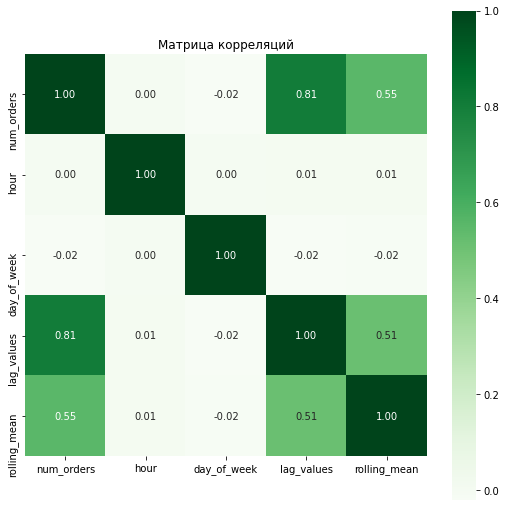

In [20]:
correlation_matrix = taxi.corr()
plt.figure(figsize=(9,9))
sns.heatmap(correlation_matrix, annot=True, cmap='Greens', fmt='.2f', square=True, cbar=True)
plt.title('Матрица корреляций')
plt.show()

- Умеренная положительная корреляция наблюдается между rolling_mean и num_orders (0.55), rolling_mean и lag_values (0.51)
- Высркая положительная корреляция между lag_values и num_orders (0.81)

Между другими парами признаков корреляция отсутствует. Однако это не значит, что остальные признаки бесполезны и их можно удалить. Коффициенты корреляции помогают установить именно линейную связь, то есть, для других признаков она может быть нелинейной.

**Вывод по корреляционному анализу данных**

Умеренная корреляция наблюдается только между месяцем и таргетом (0.51), между другими парами признаков она отсутствует.

## Подготовка данных

<a href="#Содержание">Назад к содержанию</a>

Разобъём датасет на входящие и целевой признаки и сформируем выборки (тестовая - 10%). Затем подготовим данные к обучению с помощью пайплайнов.

In [21]:
X = taxi.drop('num_orders', axis=1)
y = taxi['num_orders']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size= .1,
    shuffle=False
)
    
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

cat_features = ['hour', 'day_of_week']
num_features = ['lag_values', 'rolling_mean']

num_transformer = Pipeline(
    steps=[
    (
        'scaler',
        StandardScaler()
    )  
]
)

cat_transformer = Pipeline(
    steps=[
    (
        'ohe',
        OneHotEncoder(handle_unknown='ignore', drop='first')
    )
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        (
            'num',
            num_transformer,
            num_features
        ),
        (
            'cat',
            cat_transformer,
            cat_features
        )
    ]
)

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

(3823, 4) (425, 4) (3823,) (425,)


## Обучение и оценка моделей

<a href="#Содержание">Назад к содержанию</a>

Сначала создадим функцию, которая будет вычислять метрику rmse.

In [22]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
rmse_scorer = make_scorer(rmse, greater_is_better=False)

Теперь обучим три модели — дерево решений, линрег и градиентный бустинг с различными комбинациями параметров. На рандомизированной кроссвалидации применим нашу метрику rmse_scorer и выявим лучшую модель.

In [23]:
#Создаём пайплайн с различными вариантами моделей и их гиперпараметров
pipeline = Pipeline(
    steps=[
    (
        'model', LinearRegression()
    )  
]
)

param_grid = [
    {
        'model': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'model__max_depth': range(2, 11),
        'model__min_samples_split': range(2, 7),
        'model__min_samples_leaf': range(1, 3)
    },
    {
        'model': [LinearRegression()]
    },
       {
        'model': [lgb.LGBMRegressor(random_state=RANDOM_STATE)],
        'model__num_leaves': [31, 50],
        'model__learning_rate': [0.01, 0.1],
        'model__n_estimators': [100]
    }
]

#Проводим рандомизированную кроссвалидацию
tscv = TimeSeriesSplit(n_splits=5)

search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    scoring=rmse_scorer,
    n_iter=70,
    cv=tscv,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

search.fit(X_train_transformed, y_train)

#Сохраняем реультаты кроссвалидации в порядке убывания значения метрики
results = pd.DataFrame(search.cv_results_).sort_values(by='mean_test_score')

best_model = search.best_estimator_
best_params = search.best_params_
best_score = search.best_score_

display(F"Лучшая модель: {best_model}")
display(f"Лучшие параметры: {best_params}")
display(f"Метрика лучшей модели на кросс-валидации: {-best_score}")  

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-

"Лучшая модель: Pipeline(steps=[('model', LinearRegression())])"

"Лучшие параметры: {'model': LinearRegression()}"

'Метрика лучшей модели на кросс-валидации: 23.51986767598791'

Лучшей моделью оказалась LinearRegression. Значение rmse на кросс-валидации: 23.52


Проверим её качество на тестовой выборке.

In [24]:
y_pred = best_model.predict(X_test_transformed)
rmse(y_test, y_pred)

35.78868895200364

Значение метрики на тестовой выборке меньше 48 — успех! Также стоит проверить модель на адекватность — сравнить результаты с DummyRegressor.

In [25]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train_transformed, y_train)
y_pred_dummy = dummy_regr.predict(X_test_transformed)
rmse(y_test, y_pred_dummy)

84.45113423436631

Линрег более чем в 2 раза превосходит по качеству дамми регрессор.

## Общий вывод

<a href="#Содержание">Назад к содержанию</a>

**Загрузка и подготовка данных**

- Изначальный размер датасета — 2 признака и 26496 наблюдений;
- Названия признаков написаны в корректном змеином регистре;
- Изначально датасет состоит из двух типов данных — object (столбец datetime) и int (столбец num_orders);
- Пропусков в данных не обнаружено;
- Дубликатов в данных не обнаружено;
- По столбцу datetime тип данных заменён на datetime;
- Столбец datetime перемещён в индекс датасета, также произведено ресэмплирование данных по одному часу. В результате его длина сократилась в 6 раз (4416 строк)

**Анализ данных**

- В данные добавлено 4 новых признака — час, день недели, лаговые значения за неделю и скользяшее среднее с окном в неделю.


Визуализация и анализ признаков


- Признак num_orders распределён нормально со средним в 84.4 заказов в час. Минимальное значение 0, максимальное — 462. Также  проведена его визуализация по временным промежуткам в 2 недели. Распределение получилось такое же, как и у совокупности в целом — нормальное.

- Признак hour. Для всех часов количество наблюдений — 184, они распределены поровну.


- Признак day_of_week. Наибольшее число наблюдений было для четверга и пятницы (648), наименьшее (624) - для понедельника, вторника, среды, субботы и воскресенья.


Анализ тепловой карты


- Самое высокое среднее число заказов было в понедельник в 0:00 (168.6), а также в субботу в 0:00 (169.9)


- Также высокие значения характерны для среды в 0:00 (137.5),четверга в 0:00 (147.1), пятницы в 0:00 (145.7) и в 22:00 (146.3), субботы в 1:00 (133)


- Самое низкое среднее число заказов — вторник в 6:00 (23.2), четверг в 6:00 (14.4), воскресенье в 6:00 (20.8).


Анализ трендов, сезонности и остатков

- график тренда показывает устойчивое увеличение скользящего среднего числа заказов с течением времени. То есть, в августе в среднем заказов было больше, чем в марте;

- график сезонности показывает, что у целевого признака есть регулярные колебания. То есть, в поведении заказов действительно есть устойчивые паттерны. В определенную часть недели их среднее число увеличивается, а затем уменьшается;

- явных паттернов или трендов на графике остатков нет — они хаотичны.



Также были удалены первые 168 строк датасета: в них значения признаков 'lag_values' и 'rolling_mean' пропущены. Модель линейной регрессии не сможет обучаться на пропусках.


Вывод по корреляционному анализу данных

- Умеренная положительная корреляция наблюдается между rolling_mean и num_orders (0.55), rolling_mean и lag_values (0.51);
- Высокая положительная корреляция между lag_values и num_orders (0.81);


Между другими парами признаков корреляция отсутствует.

**Подготовка признаков, обучение и оценка моделей**

- датасет разбит на тренировочную и тестовую выборки в соотношении 9 к 1;


- установлен параметр shuffle=False, чтобы данные разбивались на выборки по порядку, а не перемешивались;


- числовые признаки промасштабированы с помощью StandardScaler, категориальные закодированы с помощью OneHotEncoder;


- обучены три модели: дерево решений, линейная регрессия и градиентный бустинг с различными комбинациями гиперпараметров. На рандомизированной кроссвалидации применена метрика rmse_scorer;


- Лучшей моделью оказалась LinearRegression. Значение rmse на кросс-валидации: 23.52


- Значение метрики на тестовой выборке для лучшей модели — 35.79. 

- Также модель проверена на адекватность с помощью DummyRegressor; его метрика на тесте - 84.45. Соответственно, линейная регрессия справляется с предсказаниями лучше.

**Рекомендации заказчику**

Рекомендую в дальнейшем собирать ещё больше информации о заказах такси, чтобы добавлять в данные новые признаки и повышать точность предсказательной модели. С ростом объёма данных лучшие предсказания может давать уже другая модель, например, линейная регрессия, или градиентный бустинг.